# MLP实现跌倒检测

In [2]:
import os
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms,datasets
import shutil
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time 

## 导入数据

In [3]:
transform=transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  ])

In [20]:
train_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/train',transform=transform)
val_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/val',transform=transform)
test_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/test',transform=transform)

In [21]:
batch_size=100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## 定义模型

In [38]:
class FlattenLayer(torch.nn.Module):
    def _init_(self):
        super(FlatenLayer,self)._init_()
    def forward(self,X):
        return X.view(X.shape[0],-1)

In [39]:
num_inputs=224*224*3
num_hiddens1=1024
num_hiddens2=512
num_outputs=3
net=torch.nn.Sequential(FlattenLayer(),torch.nn.Linear(num_inputs,num_hiddens1),torch.nn.ReLU(),torch.nn.Linear(num_hiddens1,num_hiddens2),torch.nn.ReLU(),torch.nn.Linear(num_hiddens2,num_outputs))

## 定义损失函数

In [40]:
loss=torch.nn.CrossEntropyLoss()

## 定义优化器

In [41]:
lr=1e-5
optimizer=torch.optim.Adam(net.parameters(),lr)

## 定义计算精度函数

In [42]:
def evaluate_accuracy(data_iter,net,loss):
    acc_sum=0.0
    n=0
    test_l_sum=0.0
    for X,y in data_iter:
        acc_sum+=(net(X).argmax(dim=1) == y).float().sum().item()
        l=loss(net(X),y).sum()
        test_l_sum+=l.item()
        n+=y.shape[0]
    return acc_sum/n,test_l_sum/n

## 定义训练模型函数

In [43]:
def train(net,train_iter,val_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    since=time.time()
    train_loss=[]
    val_loss=[]
    test_loss=[]
    train_acc_list=[]
    val_acc_list=[]
    test_acc_list=[]
    for epoch in range(num_epochs):
        n=0
        m=0
        testl=0.0
        train_l=0.0
        train_acc=0.0
        for X,y in train_iter:
            optimizer.zero_grad()
            y_hat= net(X)
            l =loss(y_hat, y).sum()
            l.backward()
            optimizer.step()
            train_l+=l.item()
            train_acc+=(y_hat.argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
        test_acc,testl=evaluate_accuracy(test_iter,net,loss)
        val_acc,val=evaluate_accuracy(val_iter,net,loss)
        train_loss.append(train_l/n)
        test_loss.append(testl)
        val_loss.append(val)
        train_acc_list.append(train_acc/n)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        print('epoch %d, train_l %.6f, val %.6f,testl %.6f, train_acc %.4f, val_acc %.4f, test_acc %.4f' % (epoch + 1, train_l/n, val, testl,train_acc/n,val_acc, test_acc))
    time_elapsed=(time.time()-since)/60
    print(time_elapsed)
    return  train_loss,val_loss, test_loss,train_acc_list,val_acc_list,test_acc_list

## 绘制训练集和测试集loss曲线和精度曲线

epoch 1, train_l 0.004008, val 0.004151,testl 0.007293, train_acc 0.8362, val_acc 0.8305, test_acc 0.7003
epoch 2, train_l 0.002178, val 0.005778,testl 0.008244, train_acc 0.9186, val_acc 0.7959, test_acc 0.7073
epoch 3, train_l 0.001624, val 0.006627,testl 0.008205, train_acc 0.9454, val_acc 0.7614, test_acc 0.7073
epoch 4, train_l 0.001255, val 0.006946,testl 0.008444, train_acc 0.9497, val_acc 0.7598, test_acc 0.7422
epoch 5, train_l 0.001074, val 0.006939,testl 0.008358, train_acc 0.9679, val_acc 0.7786, test_acc 0.7143
epoch 6, train_l 0.000854, val 0.007250,testl 0.008677, train_acc 0.9722, val_acc 0.7614, test_acc 0.7317
epoch 7, train_l 0.000719, val 0.008445,testl 0.009812, train_acc 0.9807, val_acc 0.7300, test_acc 0.7770
epoch 8, train_l 0.000767, val 0.007720,testl 0.009587, train_acc 0.9797, val_acc 0.7551, test_acc 0.7387
epoch 9, train_l 0.000608, val 0.008089,testl 0.009517, train_acc 0.9797, val_acc 0.7504, test_acc 0.7596
epoch 10, train_l 0.000548, val 0.008128,testl

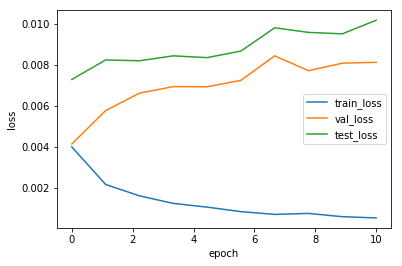

In [44]:
num_epochs=10
train_loss,val_loss,test_loss,train_acc_list,val_acc_list,test_acc_list=train(net, train_loader, val_loader, test_loader, loss, num_epochs,batch_size, lr=lr,optimizer=optimizer)
x=np.linspace(0,len(train_loss),len(test_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,val_loss,label="val_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

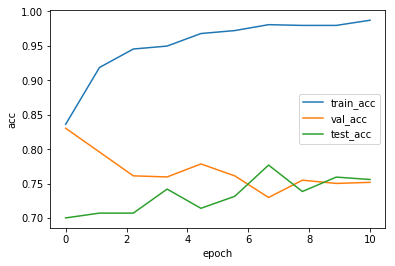

In [45]:
x=np.linspace(0,len(train_acc_list),len(test_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,val_acc_list,label="val_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()